## Data Exploration

In [53]:
%config IPCompleter.greedy=True
%matplotlib inline
import sys
import os
import pickle
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [16]:
#Create dataframe from dictionary
data_df = pd.DataFrame(data_dict)
data_df = data_df.transpose()

#Force types
numeric_features = [col for col in data_df.columns if col not in ['poi', 'email_address']]
for col in numeric_features:
    data_df[col] = data_df[col].apply(lambda c: pd.to_numeric(c, errors='coerce'))

In [17]:
data_df.sample(5)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
PAI LOU L,1000000.0,NaN,NaN,NaN,lou.pai@enron.com,15364167.0,32047.0,NaN,NaN,NaN,...,NaN,1829457.0,False,8453763.0,NaN,261879.0,NaN,NaN,3123383.0,23817930.0
MURRAY JULIA H,400000.0,NaN,NaN,NaN,julia.murray@enron.com,400478.0,57580.0,45.0,11.0,2.0,...,125000.0,330.0,False,196983.0,NaN,229284.0,395.0,2192.0,812194.0,597461.0
BIBI PHILIPPE A,1000000.0,NaN,NaN,NaN,philippe.bibi@enron.com,1465734.0,38559.0,40.0,23.0,8.0,...,369721.0,425688.0,False,378082.0,NaN,213625.0,1336.0,1607.0,2047593.0,1843816.0
CHAN RONNIE,NaN,NaN,-98784.0,98784.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,32460.0,-32460.0,NaN,NaN,NaN,NaN,NaN
GARLAND C KEVIN,850000.0,NaN,NaN,NaN,kevin.garland@enron.com,636246.0,48405.0,44.0,10.0,27.0,...,375304.0,60814.0,False,259907.0,NaN,231946.0,178.0,209.0,1566469.0,896153.0


In [23]:
data_df.info(verbose='True')

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                146 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null object
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt_with_poi      86 non-null float

We see that we have 146 entries in our dataframe, meaning that we have 146 training points.  
One column gives me one feature. There are 21 features. *POI* and *email_address* are of type string. All the other features are numerical.  
Some of our features possess some NaN values: *loan_advances*, *restricted_stock_deferred* have only 4 and 18 non NaN values respectively. So I can already exclude them from my features selection.

In [43]:
type(data_df[data_df['poi']==True].info(verbose='True'))

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, BELDEN TIMOTHY N to YEAGER F SCOTT
Data columns (total 21 columns):
bonus                        16 non-null float64
deferral_payments            5 non-null float64
deferred_income              11 non-null float64
director_fees                0 non-null float64
email_address                18 non-null object
exercised_stock_options      12 non-null float64
expenses                     18 non-null float64
from_messages                14 non-null float64
from_poi_to_this_person      14 non-null float64
from_this_person_to_poi      14 non-null float64
loan_advances                1 non-null float64
long_term_incentive          12 non-null float64
other                        18 non-null float64
poi                          18 non-null object
restricted_stock             17 non-null float64
restricted_stock_deferred    0 non-null float64
salary                       17 non-null float64
shared_receipt_with_poi      14 non-null float64

NoneType

In the dataset, there are 18 POIs. We don't always have features for POI without NaN values.

## Regression
To get a first visualization of our data, let me reuse the finance_regression.py which is part of the udacity teaching materials.

slope:  [5.44814029]
intercept:  -102360.54329387983
score on training data:  0.04550919269952436
score on test data:  -1.48499241736851
slope new regression line:  [2.27410114]


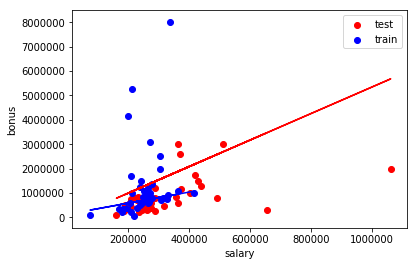

In [44]:
sys.path.append("../regression/")
import finance_regression
finance_regression.regr()

## Features selection
My hunch is that the following features shall be among the ones containing the most " information" and that they should make a good classifier:
- financial features:
    - bonus
    - exercised_stock_options
    - salary
- mail features:
    - from_poi_to_this_person
    - from_this_person_to_poi
    - shared_receipt_with_poi
    
To confirm it and also to be sure to select the most useful features, let me try using *sklearn.feature_selection.selectKbest*.

In [63]:
X = data_df.loc[:, [col for col in data_df.columns if col not in ['poi', 'email_address']]]
y = data_df.loc[:,'poi']
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').